## Домашняя работа по 3 теме "Связь бизнес-показателей и DS-метрик"
Выполнила Моисеенкова Полина

Задачи для выполнения:
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

* [Импорт библиотек и загрузка данных](#load_data)
* [Разбиение на train и test](#train_and_test)
* [Отбор признаков](#feature_selection)
* [Построение и оценка моделей](#baseline_modeling)
    * [Логистическая регрессия](#logreg)
    * [k ближайших соседей](#kmeans)
    * [Бустинговые алгоритмы](#boosting)
        * [XGBoost](#xgboost)
        * [LightGBM](#lightgbm)
        * [CatBoost](#catboost)
* [Выбор лучшей модели](#best_model)

## Импорт библиотек и загрузка данных<a class="anchor" id="load data"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

C:\Users\Полина\AppData\Local\Temp\ipykernel_13776\2324205212.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv('train_case2.csv', ';')


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


## Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=42)

C:\Users\Полина\AppData\Local\Temp\ipykernel_13776\455640767.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


## Отбор признаков<a class='anchor' id='feature_selection'></a>

К полям:
- gender, cholesterol, gluc применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol', 'gluc']
base_cols = ['smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.09144178,  0.44594423,  0.05752649, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.46216539,  0.20194394, -0.84752919, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.5702846 , -1.01805752,  1.79801819, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67238553,  0.56794437, -0.01209318, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50009534,  0.32394408, -0.29057185, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76136594,  1.54394554, -0.70828985, ...,  0.        ,
         0.        ,  1.        ]])

### Построение и оценка моделей<a class="anchor" id="baseline_modeling"></a> 

Напишем функцию, которая позволит оценить качество моделей

In [7]:
def get_classification_report(y_test, y_score, b=1):

    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")
    plt.figure(figsize=(5, 4))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

    precision, recall, thresholds = precision_recall_curve(
        y_test, y_score)
    fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    print(f'ROC_AUC score is: {roc_auc_score(y_test, y_score)}')
    return {'fscore': fscore[ix], 'precision': precision[ix],
            'recall': recall[ix], 'roc_auc_score': roc_auc_score(y_test, y_score)}
                                                            

Напишем функцию для валидации, построения и обучения модели

## Логистическая регрессия <a class='anchor' id='logreg'></a>

In [8]:
ML_function = LogisticRegression(random_state=42)

In [9]:
def ML_algorithm(ML_function):
    classifier = Pipeline([
        ('features',feats),
        ('classifier', ML_function),
    ])


    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    y_test_pred = classifier.predict(X_test)
    results = {'y_score': y_score, 'y_test_pred': y_test_pred, 'classifier': classifier}
    return results

In [10]:
%%time
logreg = ML_algorithm(ML_function)

CPU times: total: 8.53 s
Wall time: 5.41 s


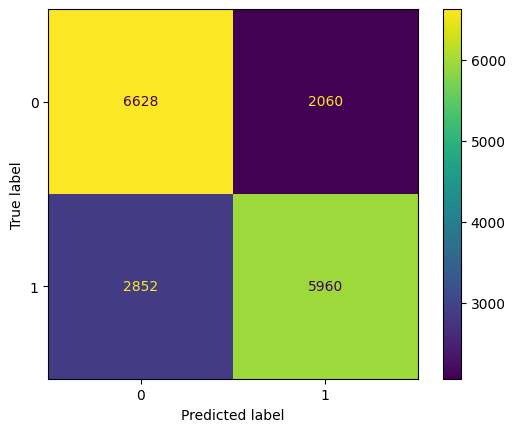

In [11]:
ConfusionMatrixDisplay.from_estimator(logreg['classifier'], X_test, y_test)

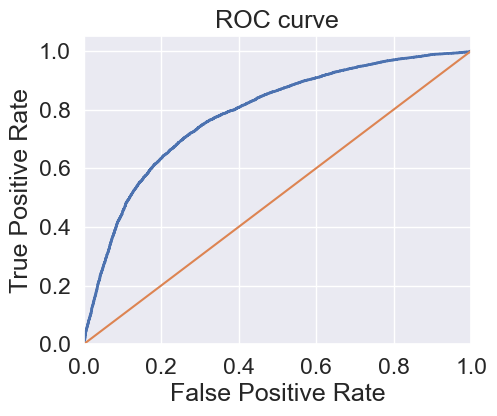

Best Threshold=0.392883, F-Score=0.736, Precision=0.653, Recall=0.844
ROC_AUC score is: 0.7855176559003334


In [12]:
logreg_report = get_classification_report(y_test=np.array(y_test),
                        y_score=logreg['y_score'])

## k ближайших соседей <a class='anchor' id='kmeans'></a>

In [13]:
ML_function = KNeighborsClassifier()
kmeans = ML_algorithm(ML_function)

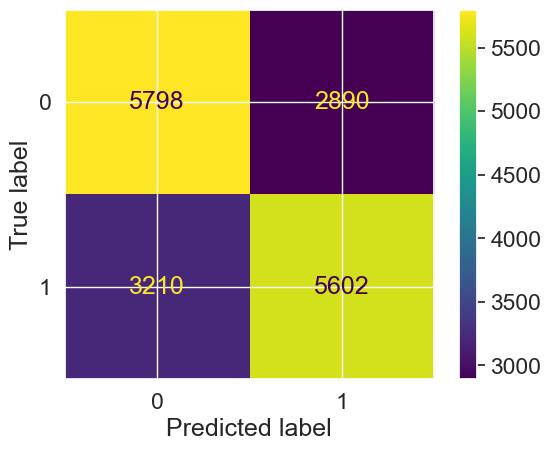

In [14]:
ConfusionMatrixDisplay.from_estimator(kmeans['classifier'], X_test, y_test)

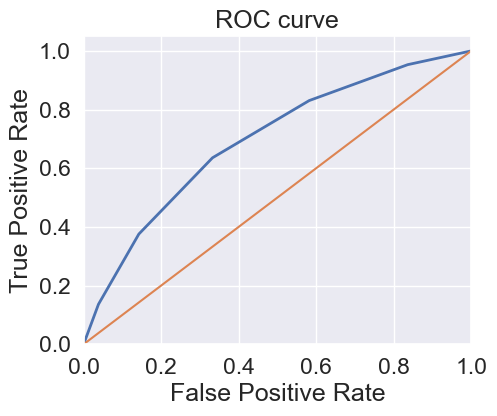

Best Threshold=0.400000, F-Score=0.691, Precision=0.591, Recall=0.831
ROC_AUC score is: 0.6949201080541435


In [15]:
kmeans_report = get_classification_report(y_test=np.array(y_test),
                        y_score=kmeans['y_score'])

Алгоритм "К ближайших соседей" дал хуже результат, чем модель с логистической регрессией

## Бустинговые алгоритмы <a class='anchor' id='boosting'></a>

*XGBoost* <a class='anchor' id='xgboost'></a>

In [16]:
XGBoost = ML_algorithm(ML_function=xgb.XGBClassifier(random_state=42))

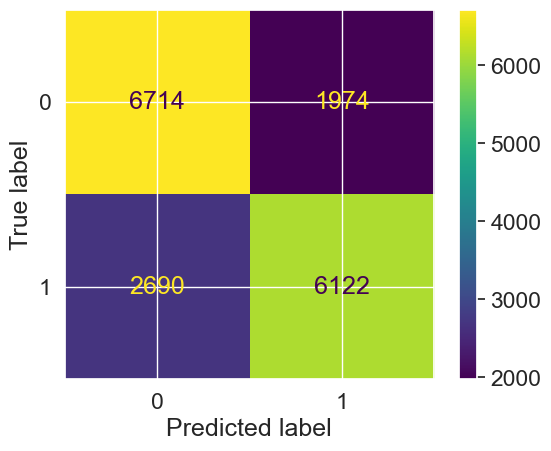

In [17]:
ConfusionMatrixDisplay.from_estimator(XGBoost['classifier'], X_test, y_test)

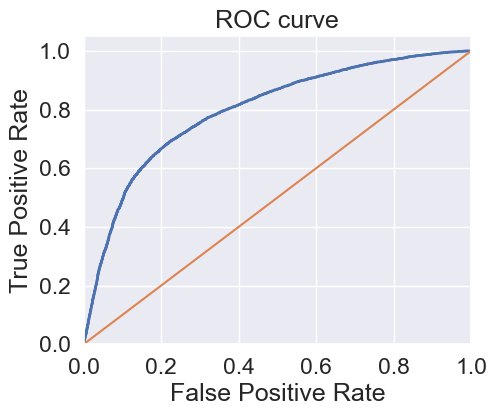

Best Threshold=0.391569, F-Score=0.740, Precision=0.695, Recall=0.792
ROC_AUC score is: 0.7975984714256217


In [18]:
XGBoost_report = get_classification_report(y_test=np.array(y_test),
                        y_score=XGBoost['y_score'])

Пока это самый лучший результат, посмотрим на другой бустинговый алгоритм

*LightGBM* <a class='anchor' id='lightgbm'></a>

In [19]:
lightGBM = ML_algorithm(ML_function=lgbm.LGBMClassifier(random_state=21))

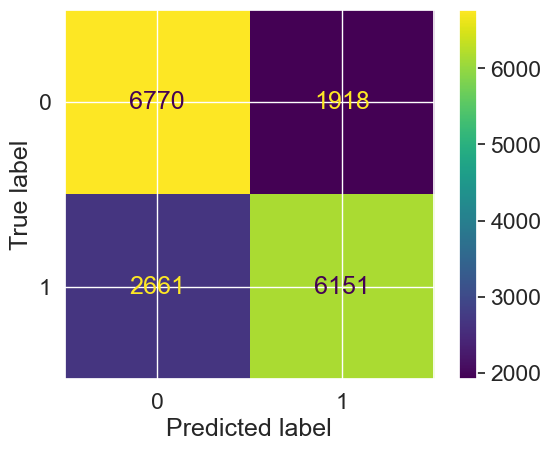

In [20]:
ConfusionMatrixDisplay.from_estimator(lightGBM['classifier'], X_test, y_test)

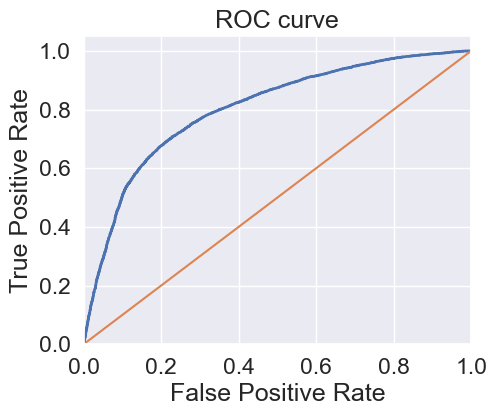

Best Threshold=0.410262, F-Score=0.746, Precision=0.711, Recall=0.785
ROC_AUC score is: 0.8026741221789473


In [21]:
lightGBM_report = get_classification_report(y_test=np.array(y_test),
                        y_score=lightGBM['y_score'])

lightGBM дает лучше результат, чем XGBoost

*CatBoost* <a class='anchor' id='catboost'></a>

In [22]:
CatBoost = ML_algorithm(ML_function=catb.CatBoostClassifier(silent=True, random_state=21))

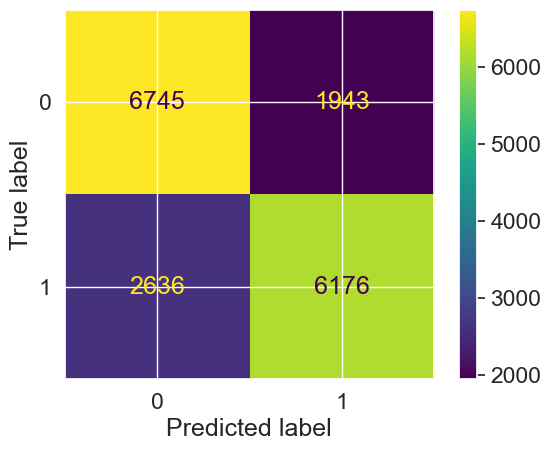

In [23]:
ConfusionMatrixDisplay.from_estimator(CatBoost['classifier'], X_test, y_test)

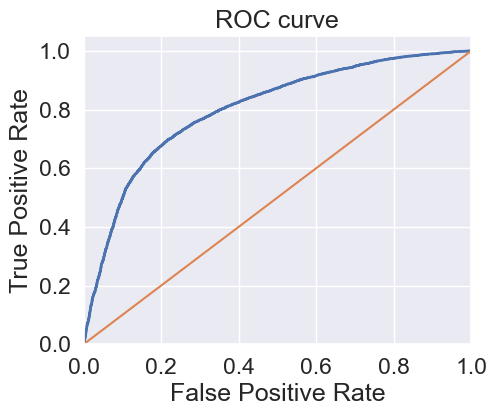

Best Threshold=0.379012, F-Score=0.745, Precision=0.690, Recall=0.810
ROC_AUC score is: 0.8018842506848605


In [24]:
CatBoost_report = get_classification_report(y_test=np.array(y_test),
                        y_score=CatBoost['y_score'])

CatBoost оказался самым меделенным алгоритмом и немного проигрывает по показателям LightGBM

In [25]:
all_reports = [logreg_report, kmeans_report, XGBoost_report, lightGBM_report, CatBoost_report]

In [26]:
table = {'precision': [report['precision'].round(3) for report in all_reports],
        'recall': [report['recall'].round(3) for report in all_reports],
        'roc_auc_score': [report['roc_auc_score'].round(3) for report in all_reports],
        'f_score': [report['fscore'].round(3) for report in all_reports]}
table = pd.DataFrame(data=table, index=['Logistic Regression', 'K-mean', 'XGBoost', 'LightGBM', 'CatBoost'])
table

,precision,recall,roc_auc_score,f_score
Logistic Regression,0.653,0.844,0.786,0.736
K-mean,0.591,0.831,0.695,0.691
XGBoost,0.695,0.792,0.798,0.740
LightGBM,0.711,0.785,0.803,0.746
CatBoost,0.690,0.810,0.802,0.745


## Выбор лучшей модели <a class='anchor' id='best_model'></a>

Самой лучшей моделью оказалась модель с алгоритмом LightGBM.

*LightGBM предлагает одностороннюю выборку на основе градиента (GOSS), которая выбирает разделение, используя все экземпляры с большими градиентами (то есть с большой ошибкой) и случайную выборку экземпляров с небольшими градиентами. Чтобы сохранить такое же распределение данных при вычислении прироста информации, GOSS вводит постоянный множитель для экземпляров данных с небольшими градиентами. Таким образом, GOSS достигает хорошего баланса между увеличением скорости за счет уменьшения количества экземпляров данных и сохранением точности для изученных деревьев решений. LightGBM использует рост деревьев по листьям (лучший - первым). Он выбирает рост листа, который сводит к минимуму потери, позволяя вырасти несбалансированному дереву. Поскольку он растет не по уровням, а по листам, переобучение может произойти, когда данных мало. В этих случаях важно контролировать глубину дерева. LightGBM и XGBoost имеют два схожих метода: первый - это «усиление», которое представляет собой повышение точности (или общего усиления), обеспечиваемое функцией для ветвей, в которых она находится. Второй метод имеет свое имя в каждом пакете: «split» (LightGBM) и «Frequency» / «Weight» (XGBoost). Этот метод вычисляет относительное количество раз, когда конкретный элемент встречается во всех разбиениях деревьев модели. Этот метод может быть искажен категориальными признаками с большим количеством категорий. LightGBM разделяет категориальные функции, разделяя их категории на 2 подмножества. Основная идея состоит в том, чтобы отсортировать категории в соответствии с целями тренировки на каждой группе. LightGBM - самый быстрый из всех алгоритмов.*